# 02 — Nettoyage & préparation des données (consommation + météo)

Ce notebook prépare les **datasets propres** utilisés dans la suite du projet *Stress Grid* :

1. **Consommation nationale** : consolidation des fichiers `consommation_YYYY_long.csv` (pas 30 min) → `consommation_clean.parquet`
2. **Météo multi-villes** : nettoyage + contrôle de continuité horaire → agrégation nationale → `weather_national_hourly.parquet`
3. **Alignement temporel** : consommation (resample horaire) + météo nationale (horaire) → `dataset_model_hourly.parquet`

> Remarque : le “trou” 2020 (mai→septembre) est une **absence de données source** et n’est pas imputé dans le baseline.


## 0. Imports & configuration

Le code “lourd” est déporté dans `src/data/` afin de garder ce notebook lisible (orchestration + contrôles).


In [1]:
import os


if os.getcwd().endswith("notebooks"):
    os.chdir("..")

print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /home/onyxia/france-grid-stress-prediction


In [2]:
import pandas as pd
import sys
from pathlib import Path



# On fixe le chemin "en dur"
PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")

# Ajoute la racine du projet en priorité (avant site-packages)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


DATA_DIR = PROJECT_ROOT / "data"
DATA_RAW = DATA_DIR / "interim"
DATA_PROCESSED = DATA_DIR / "processed"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_RAW exists:", DATA_RAW.exists())
print("DATA_PROCESSED exists:", DATA_PROCESSED.exists())





PROJECT_ROOT: /home/onyxia/france-grid-stress-prediction
DATA_RAW exists: True
DATA_PROCESSED exists: True


In [3]:
import sys
sys.path.append("/home/onyxia/france-grid-stress-prediction/src")

import pandas as pd
from pathlib import Path

from data.prophet_fill import fill_missing_with_prophet

import importlib, sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

print("Trying import src ...")
import src
print("src imported from:", src.__file__ if hasattr(src, "__file__") else src)

print("Trying import src.data ...")
import src.data
print("src.data imported from:", src.data.__file__ if hasattr(src.data, "__file__") else src.data)


/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Trying import src ...
src imported from: /home/onyxia/france-grid-stress-prediction/src/__init__.py
Trying import src.data ...
src.data imported from: /home/onyxia/france-grid-stress-prediction/src/data/__init__.py


## 1. Consommation électrique — nettoyage et consolidation

- Standardisation des colonnes (`datetime`, `load_mw`)
- Tri temporel + déduplication
- Contrôle simple de continuité (pas attendu = 30 min)
- Export en Parquet


In [4]:
from src.data.consumption_cleaning import ConsumptionCleanConfig, build_consumption_dataset


cfg_cons = ConsumptionCleanConfig(
    raw_dir=DATA_RAW / "consommation",   
    out_path=DATA_PROCESSED / "consommation_clean.parquet",
    pattern="consommation_*_long.csv",
)

df_cons, report_cons = build_consumption_dataset(cfg_cons)






### 1.1 Contrôles rapides

- Bornes temporelles
- Unicité de `datetime`
- Pas de temps observé (distribution des deltas)


In [5]:
df_cons["datetime"].min(), df_cons["datetime"].max(), len(df_cons), df_cons["datetime"].is_unique


(Timestamp('2010-01-01 00:00:00'),
 Timestamp('2024-12-31 23:30:00'),
 252672,
 True)

In [6]:
df_cons = df_cons.sort_values("datetime")
df_cons["datetime"].diff().value_counts().head(10)


datetime
0 days 00:30:00      252669
154 days 00:30:00         1
61 days 00:30:00          1
Name: count, dtype: int64

## 2. Météo — nettoyage, contrôle, agrégation nationale

- Nettoyage : colonnes, datetime (UTC → naïf), doublons (`city`, `datetime`)
- Contrôle de continuité horaire **par ville**
- Agrégation nationale : moyenne horaire sur l’ensemble des villes


In [13]:
from src.data.weather_cleaning import WeatherCleanConfig, build_weather_national_dataset
from pathlib import Path

raw_dir = Path("data/raw/weather")          # <-- adapte
out_path = Path("data/processed/weather_national_hourly.parquet")  

cfg_w = WeatherCleanConfig(raw_dir=raw_dir, out_path=out_path)

df_weather_nat, report_weather = build_weather_national_dataset(cfg_w)

display(report_weather.head(10))
df_weather_nat.head()



,city,rows,min_dt,max_dt,n_bad_steps
0,Angers,131496,2010-01-01,2024-12-31 23:00:00,0
1,Avignon,131496,2010-01-01,2024-12-31 23:00:00,0
2,Bordeaux,131496,2010-01-01,2024-12-31 23:00:00,0
3,Brest,131496,2010-01-01,2024-12-31 23:00:00,0
4,Béthune,131496,2010-01-01,2024-12-31 23:00:00,0
5,Caen,131496,2010-01-01,2024-12-31 23:00:00,0
6,Clermont-Ferrand,131496,2010-01-01,2024-12-31 23:00:00,0
7,Dijon,131496,2010-01-01,2024-12-31 23:00:00,0
8,Douai - Lens,131496,2010-01-01,2024-12-31 23:00:00,0
9,Genève - Annemasse (partie française),131496,2010-01-01,2024-12-31 23:00:00,0


,datetime,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover
0,2010-01-01 00:00:00,4.273719,12.397994,0.0,0.0,93.96875
1,2010-01-01 01:00:00,4.036219,12.709288,0.0,0.0,95.40625
2,2010-01-01 02:00:00,3.812781,13.122019,0.0,0.0,96.46875
3,2010-01-01 03:00:00,3.598719,13.308270,0.0,0.0,96.87500
4,2010-01-01 04:00:00,3.426844,14.081800,0.0,0.0,94.78125


In [ ]:
w = pd.read_parquet(DATA_PROCESSED / "weather_national_hourly.parquet")
w["datetime"] = pd.to_datetime(w["datetime"])
print("weather years:", sorted(w["datetime"].dt.year.unique())[:5], "...", sorted(w["datetime"].dt.year.unique())[-5:])


weather years: [np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014)] ... [np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]


## 3. Alignement temporel et fusion (baseline)

- Consommation : resample horaire (moyenne)
- Fusion sur `datetime` (inner join)
- Contrôles : doublons, continuité horaire


In [ ]:
from src.data.merge_datasets import MergeConfig, build_hourly_dataset

cfg_merge = MergeConfig(
    consumption_path=DATA_PROCESSED / "consommation_clean.parquet",
    weather_path=DATA_PROCESSED / "weather_national_hourly.parquet",
    out_path=DATA_PROCESSED / "dataset_model_hourly.parquet",
)

df_model = build_hourly_dataset(cfg_merge)
df_model.head()


/home/onyxia/france-grid-stress-prediction/src/data/merge_datasets.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


,datetime,load_mw,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover
0,2010-01-01 00:00:00,52685.0,4.273719,12.397994,0.0,0.0,93.96875
1,2010-01-01 01:00:00,52142.5,4.036219,12.709288,0.0,0.0,95.40625
2,2010-01-01 02:00:00,52081.5,3.812781,13.122019,0.0,0.0,96.46875
3,2010-01-01 03:00:00,52331.5,3.598719,13.308270,0.0,0.0,96.87500
4,2010-01-01 04:00:00,52171.0,3.426844,14.081800,0.0,0.0,94.78125


In [ ]:
# Contrôles de base
df_model["datetime"].duplicated().sum(), df_model["datetime"].diff().value_counts().head(5)


(np.int64(0),
 datetime
 0 days 01:00:00    131495
 Name: count, dtype: int64)

## 4. Focus : diagnostic du “trou” 2020 (consommation)

Objectif : vérifier que la discontinuité en 2020 provient bien des **fichiers source**.

- On filtre 2020 dans le dataset propre
- On compare la distribution mensuelle avec le fichier brut 2020


In [ ]:
df_cons_2020 = df_cons[df_cons["datetime"].dt.year == 2020].copy()
df_cons_2020["month"] = df_cons_2020["datetime"].dt.month
df_cons_2020.groupby("month").size()


month
1     1488
2     1392
3     1488
4     1440
10    1440
dtype: int64

In [ ]:
raw_2020_path = DATA_RAW / "consommation" / "consommation_2020_long.csv"
df_raw_2020 = pd.read_csv(raw_2020_path)
pd.to_datetime(df_raw_2020["datetime"]).dt.month.value_counts().sort_index()


datetime
1     1488
2     1392
3     1488
4     1440
10    1440
Name: count, dtype: int64

## (Optionnel) Reconstruction contrefactuelle des valeurs manquantes (Prophet)

Cette section produit une **version alternative** du dataset horaire dans laquelle les périodes manquantes
de consommation sont **remplies par un modèle Prophet** entraîné sur les observations disponibles.

**Important :** cette étape est réalisée **uniquement à des fins de comparaison méthodologique**
(baseline sans interpolation vs baseline avec comblement). Elle ne constitue pas une méthode d’imputation
retenue pour un usage opérationnel.


In [ ]:
PATH = "/home/onyxia/france-grid-stress-prediction/data/processed/dataset_model_hourly.parquet"
df = pd.read_parquet(PATH)

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131496 entries, 0 to 131495
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datetime           131496 non-null  datetime64[ns]
 1   load_mw            126336 non-null  float64       
 2   temperature_2m     131496 non-null  float64       
 3   wind_speed_10m     131496 non-null  float64       
 4   direct_radiation   131496 non-null  float64       
 5   diffuse_radiation  131496 non-null  float64       
 6   cloud_cover        131496 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 7.0 MB


,datetime,load_mw,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover
0,2010-01-01 00:00:00,52685.0,4.273719,12.397994,0.0,0.0,93.96875
1,2010-01-01 01:00:00,52142.5,4.036219,12.709288,0.0,0.0,95.40625
2,2010-01-01 02:00:00,52081.5,3.812781,13.122019,0.0,0.0,96.46875
3,2010-01-01 03:00:00,52331.5,3.598719,13.308270,0.0,0.0,96.87500
4,2010-01-01 04:00:00,52171.0,3.426844,14.081800,0.0,0.0,94.78125


## Déf du dataset de Prophet

In [ ]:
import pandas as pd

df_prophet = (
    df[['datetime', 'load_mw']]
    .rename(columns={'datetime': 'ds', 'load_mw': 'y'})
    .copy()
)

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [ ]:
from prophet import Prophet
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/home/onyxia/france-grid-stress-prediction/data/processed")
PATH = DATA_DIR / "dataset_model_hourly.parquet"

df = pd.read_parquet(PATH)
df["datetime"] = pd.to_datetime(df["datetime"])

# Prophet input
df_prophet = df[["datetime", "load_mw"]].rename(columns={"datetime": "ds", "load_mw": "y"}).copy()

m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05
)

# Fit
m.fit(df_prophet)

# Predict on the same timestamps
future = df[["datetime"]].rename(columns={"datetime": "ds"})
forecast = m.predict(future)

# Merge predictions
df_filled = df.merge(
    forecast[["ds", "yhat"]],
    left_on="datetime",
    right_on="ds",
    how="left"
)

# (Optionnel) Remplir seulement si NaN
mask = df_filled["load_mw"].isna()
df_filled.loc[mask, "load_mw"] = df_filled.loc[mask, "yhat"]

# Garder une trace de ce qui a été rempli
df_filled["filled_by_prophet"] = mask

df_filled = df_filled.drop(columns=["ds", "yhat"])

OUT_PROPHET = DATA_DIR / "dataset_model_hourly_prophetfilled.parquet"
df_filled.to_parquet(OUT_PROPHET, index=False)

OUT_PROPHET




13:43:16 - cmdstanpy - INFO - Chain [1] start processing


## Sanity Check Prophet

In [ ]:
print("NaN avant :", df['load_mw'].isna().sum())
print("NaN après :", df_filled['load_mw'].isna().sum())

NaN avant : 5160
NaN après : 0


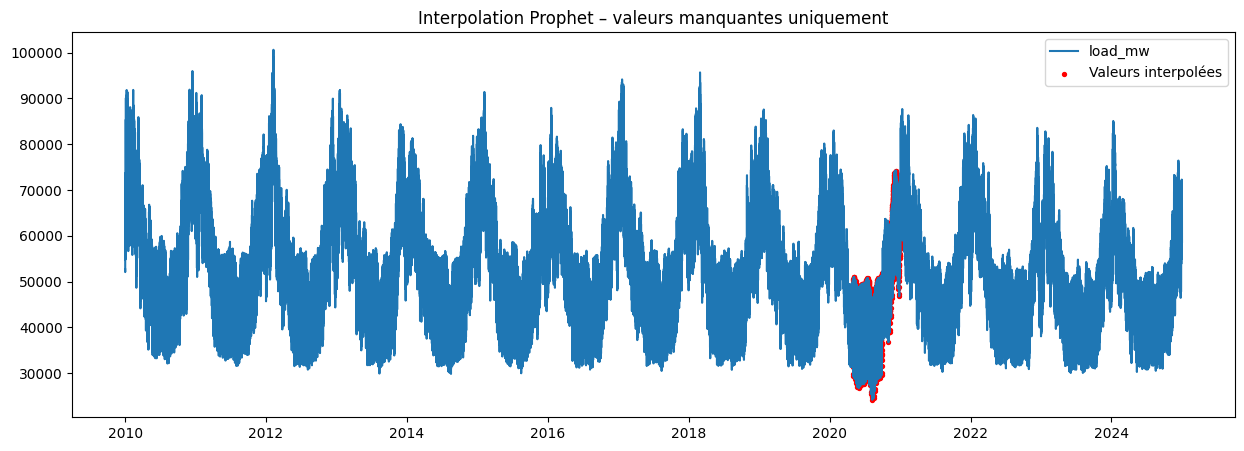

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df_filled['datetime'], df_filled['load_mw'], label='load_mw')
plt.scatter(
    df.loc[df['load_mw'].isna(), 'datetime'],
    df_filled.loc[df['load_mw'].isna(), 'load_mw'],
    color='red',
    s=8,
    label='Valeurs interpolées'
)
plt.legend()
plt.title("Interpolation Prophet – valeurs manquantes uniquement")
plt.show()


## 5. Sorties

- `data/processed/consommation_clean.parquet`
- `data/processed/weather_national_hourly.parquet`
- `data/processed/dataset_model_hourly.parquet`
- `data/processed/dataset_model_hourly_prophetfilled.parquet`


## 📊 Data Quality Report

Cette section synthétise les principales caractéristiques et contrôles de qualité
des jeux de données utilisés avant l’étape de feature engineering.

### 🔹 Couverture temporelle

- **Consommation électrique**  
  - Période : {{cons_coverage.start}} → {{cons_coverage.end}}  
  - Nombre d’années couvertes : {{cons_coverage.n_years}}

- **Données météorologiques (nationales)**  
  - Période : {{weather_coverage.start}} → {{weather_coverage.end}}  
  - Nombre d’années couvertes : {{weather_coverage.n_years}}

- **Dataset final de modélisation**  
  - Période : {{model_coverage.start}} → {{model_coverage.end}}  
  - Nombre d’années couvertes : {{model_coverage.n_years}}

### 🔹 Fréquence temporelle

- Consommation : semi-horaire agrégée à l’heure
- Météo : horaire
- Dataset final : **horaire**

### 🔹 Valeurs manquantes

- Les valeurs manquantes sont limitées et directement liées aux données source.
- Aucune interpolation automatique n’a été appliquée au dataset de référence.
- Une rupture structurelle est identifiée entre **mai et septembre 2020**, due à
  l’absence de données de consommation dans les fichiers source.

### 🔹 Décisions méthodologiques

- Le dataset sans interpolation constitue la **référence principale** pour la modélisation.
- Une reconstruction contrefactuelle via Prophet est utilisée uniquement à des fins
  de comparaison méthodologique et non comme solution opérationnelle.

### 🔹 Conclusion

Les données sont cohérentes, traçables et prêtes pour l’étape de feature engineering.
Les principales limitations sont identifiées et documentées, sans impact sur la
validité méthodologique de l’analyse.


In [ ]:
pd.DataFrame({
    "Consommation (%)": cons_missing,
    "Météo (%)": weather_missing,
    "Dataset modèle (%)": model_missing,
}).fillna(0)


,Consommation (%),Météo (%),Dataset modèle (%)
cloud_cover,0.0,0.0,0.00
datetime,0.0,0.0,0.00
diffuse_radiation,0.0,0.0,0.00
direct_radiation,0.0,0.0,0.00
load_mw,0.0,0.0,3.92
temperature_2m,0.0,0.0,0.00
wind_speed_10m,0.0,0.0,0.00
